In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn import tree
import pandas as pd
plt.style.use('seaborn-poster')

## Generate data

Let's first generate a toy dataset that we will use a Random Forest model to fit it. We generate a periodical dataset using two sine wave with different period, and then add some noise to it. It can be visualized in the following figure:

<ErrorbarContainer object of 3 artists>

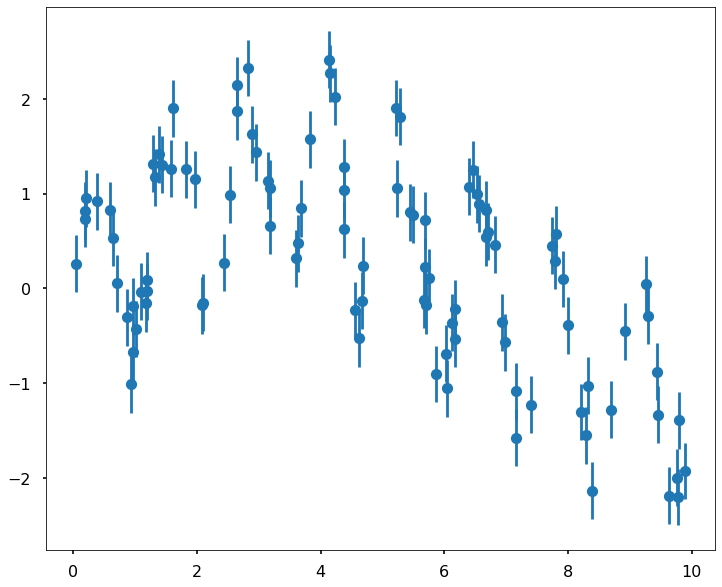

In [2]:
np.random.seed(0)
x = 10 * np.random.rand(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

plt.figure(figsize = (12,10))
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o')

## Fit a Random Forest Model

In this section, we fit a random forest model with 50 trees, and all the other parameters are using the default. 

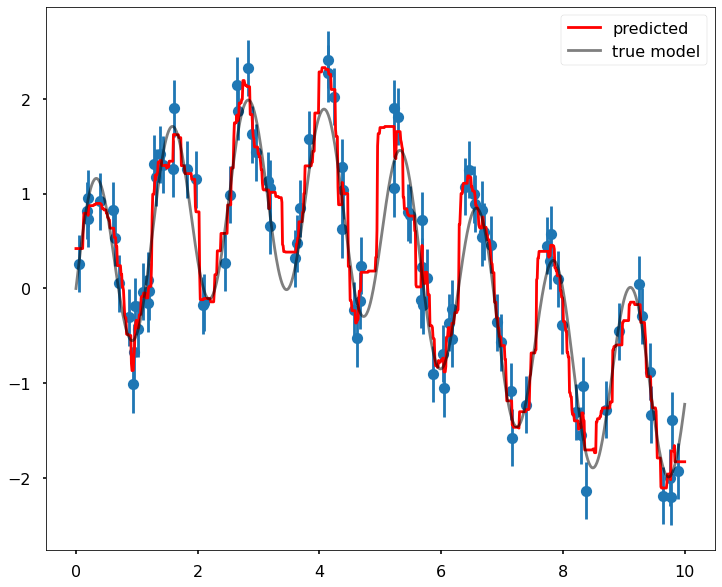

In [3]:
xfit = np.linspace(0, 10, 1000)

clf = RandomForestRegressor(n_estimators=50, random_state=42)
clf.fit(x[:, None], y)
# fit the model and get the estimation for each data points
yfit = clf.predict(xfit[:, None])
ytrue = model(xfit, 0)

plt.figure(figsize = (12,10))
plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r', label = 'predicted', zorder = 10)
plt.plot(xfit, ytrue, '-k', alpha=0.5, label = 'true model', zorder = 10)
plt.legend()

Print out the misfit using the mean squared error.

In [4]:
mse = mean_squared_error(ytrue, yfit)
print(mse)

0.09614521090819785


We can also plot the tree structure for different trees in the forest. 



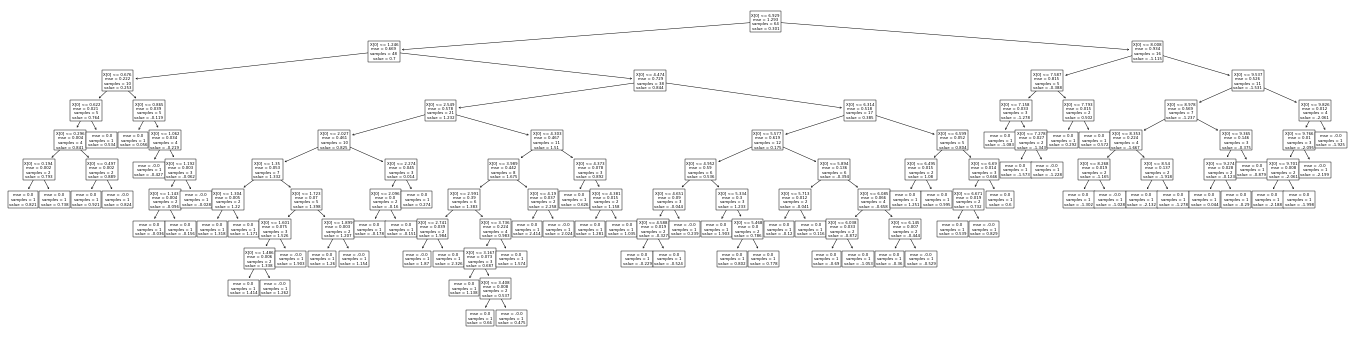

In [5]:
fig = plt.figure(figsize=(24, 6))
ax = plt.subplot(111)
tree.plot_tree(clf.estimators_[0], ax=ax)
plt.show()

In [6]:
RandomForestRegressor?

Let's change some of the default arguments, (1) we also set the minumum number of samples at the leaf is 2 and (2) we want to get the out-of-bag score. 


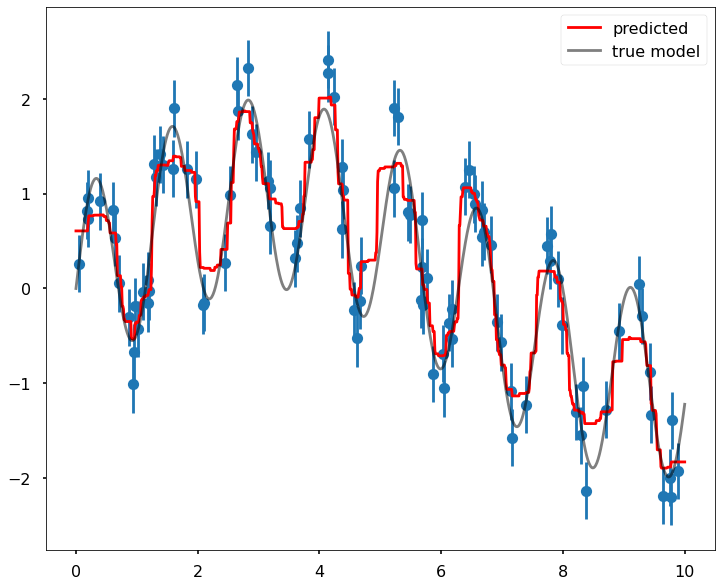

In [8]:
clf = RandomForestRegressor(n_estimators=50, random_state=42,
                            min_samples_leaf=2, oob_score=True)
clf.fit(x[:, None], y)
# fit the model and get the estimation for each data points
yfit = clf.predict(xfit[:, None])
ytrue = model(xfit, 0)

plt.figure(figsize = (12,10))
plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r', label = 'predicted', zorder = 10)
plt.plot(xfit, ytrue, '-k', alpha=0.5, label = 'true model', zorder = 10)
plt.legend()

In [9]:
print(f"oob error is: {1 - clf.oob_score_}")

oob error is: 0.16268132744603636


## Real world example

Let's play a real world example and see a more detailed working pipeline using random forest. We will use the Boston house prices dataset which has multiple features to estimate the prices of the house. We will use `GridSearchCV` which is using cross-validation with gridsearch over a range of hyper-parameters to search for the best combination. We just show a simple example, feel free to play with the different ranges with the hyper-parameters. 

In [ ]:
boston = datasets.load_boston()

In [ ]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In machine learning, it is always good to split your data into training and testing sets, where you only use the training data to tune and train your model. Then after the training procedure is done, you can evaluate the performance on the never used test data to give you an idea of the generalization capability of the trained model. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, train_size=0.80, 
    test_size=0.20, random_state=42)

In [ ]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
y_preds = rf_regressor.predict(X_test)

# print the estimate and true test values
print([f'({i:.1f},{j:.1f})' for i,j in zip(y_preds[:8],y_test[:8])])

print(f'Training Coefficient of R^2 : {rf_regressor.score(X_train, y_train):.3f}')
print(f'Test Coefficient of R^2 : {rf_regressor.score(X_test, y_test):.3f}')

['(22.9,23.6)', '(30.5,32.4)', '(16.4,13.6)', '(23.5,22.8)', '(16.9,16.1)', '(21.4,20.0)', '(19.3,17.8)', '(15.8,14.0)']
Training Coefficient of R^2 : 0.977
Test Coefficient of R^2 : 0.890


In [ ]:
n_samples = boston.data.shape[0]
n_features = boston.data.shape[1]

params = {'n_estimators': [20,50],
          'max_depth': [None, 2, 5],
          'min_samples_split': [2, 3 ],
          'min_samples_leaf': [1, 2],
          'criterion': ['mse', 'mae'],
          'max_features': [None, 'sqrt', 'auto', 'log2', 0.3],
          'bootstrap':[True, False]
         }

rf_regressor_grid = GridSearchCV(RandomForestRegressor(random_state=1), param_grid=params, n_jobs=-1, cv=2, verbose=1)
rf_regressor_grid.fit(X_train,y_train)

print(f'Train R^2 Score : {rf_regressor_grid.best_estimator_.score(X_train, y_train):.3f}')
print(f'Test R^2 Score : {rf_regressor_grid.best_estimator_.score(X_test, y_test):.3f}')
print(f'Best R^2 Score Through Grid Search : {rf_regressor_grid.best_score_:.3f}')
print(f'Best Parameters : {rf_regressor_grid.best_params_}')

Fitting 2 folds for each of 480 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   56.0s


Train R^2 Score : 0.968
Test R^2 Score : 0.815
Best R^2 Score Through Grid Search : 0.838
Best Parameters : {'bootstrap': True, 'criterion': 'mae', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.1min finished


In [ ]:
cross_val_results = pd.DataFrame(rf_regressor_grid.cv_results_)
print(f'Number of Various Combinations of Parameters Tried : {len(cross_val_results)}')

cross_val_results.head()


Number of Various Combinations of Parameters Tried : 480


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063955,0.003537,0.003634,0.000088,True,mse,None,None,1,2,20,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.751150,0.834523,0.792837,0.041686,237
1,0.152115,0.003927,0.007240,0.000174,True,mse,None,None,1,2,50,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.758930,0.839683,0.799307,0.040377,180
2,0.059516,0.001611,0.003471,0.000077,True,mse,None,None,1,3,20,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.746980,0.830159,0.788569,0.041590,251
3,0.154954,0.000089,0.007088,0.000147,True,mse,None,None,1,3,50,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.758840,0.840372,0.799606,0.040766,174
4,0.065922,0.002682,0.003502,0.000108,True,mse,None,None,2,2,20,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.774573,0.835151,0.804862,0.030289,162


### The best estimator and feature importance

We can take a look of the best estimator and the importance of the features based on the metrics. The feature importance can be obtained by monitoring how much impurity decreases for each feature, the most important feature is the one that has the maximum decrease. 

In [ ]:
best_estimator = rf_regressor_grid.best_estimator_
best_estimator

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

Let's plot the feature importance. 

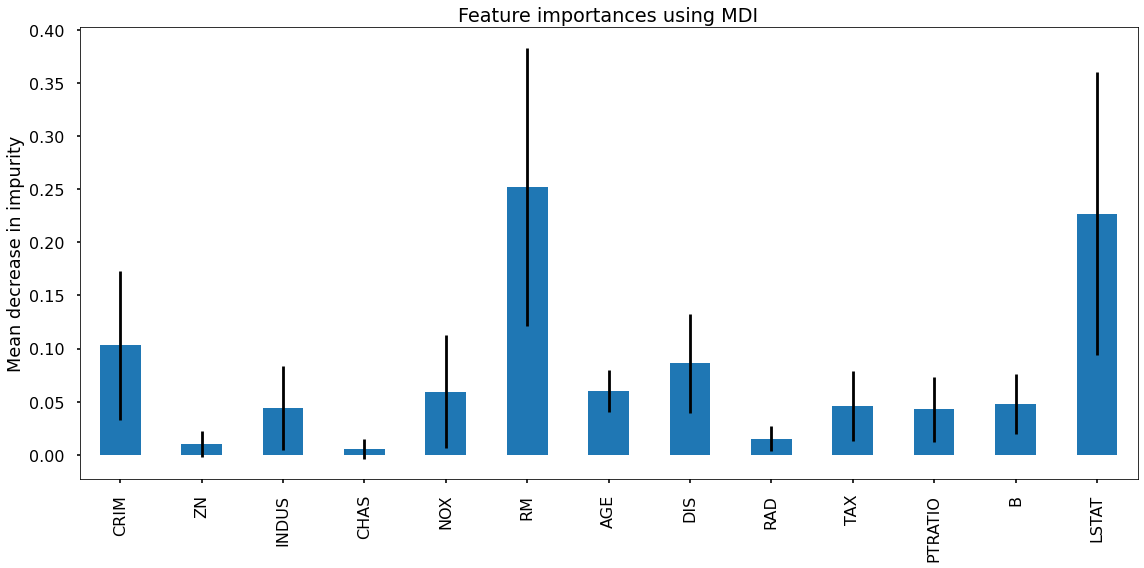

In [ ]:
importances = best_estimator.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in best_estimator.estimators_], axis=0)

forest_importances = pd.Series(importances, index=boston.feature_names)

fig, ax = plt.subplots(figsize=(16, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We can also take a look of the scatter matrix plot of all the features as well as the target. From this figure, we can see which features correlate with others and which features correlate with the target better. We can see that RM, LSTAT and CRIM are the most important 3 features. But also we can see that RM and LSTAT are correlated with each other. 

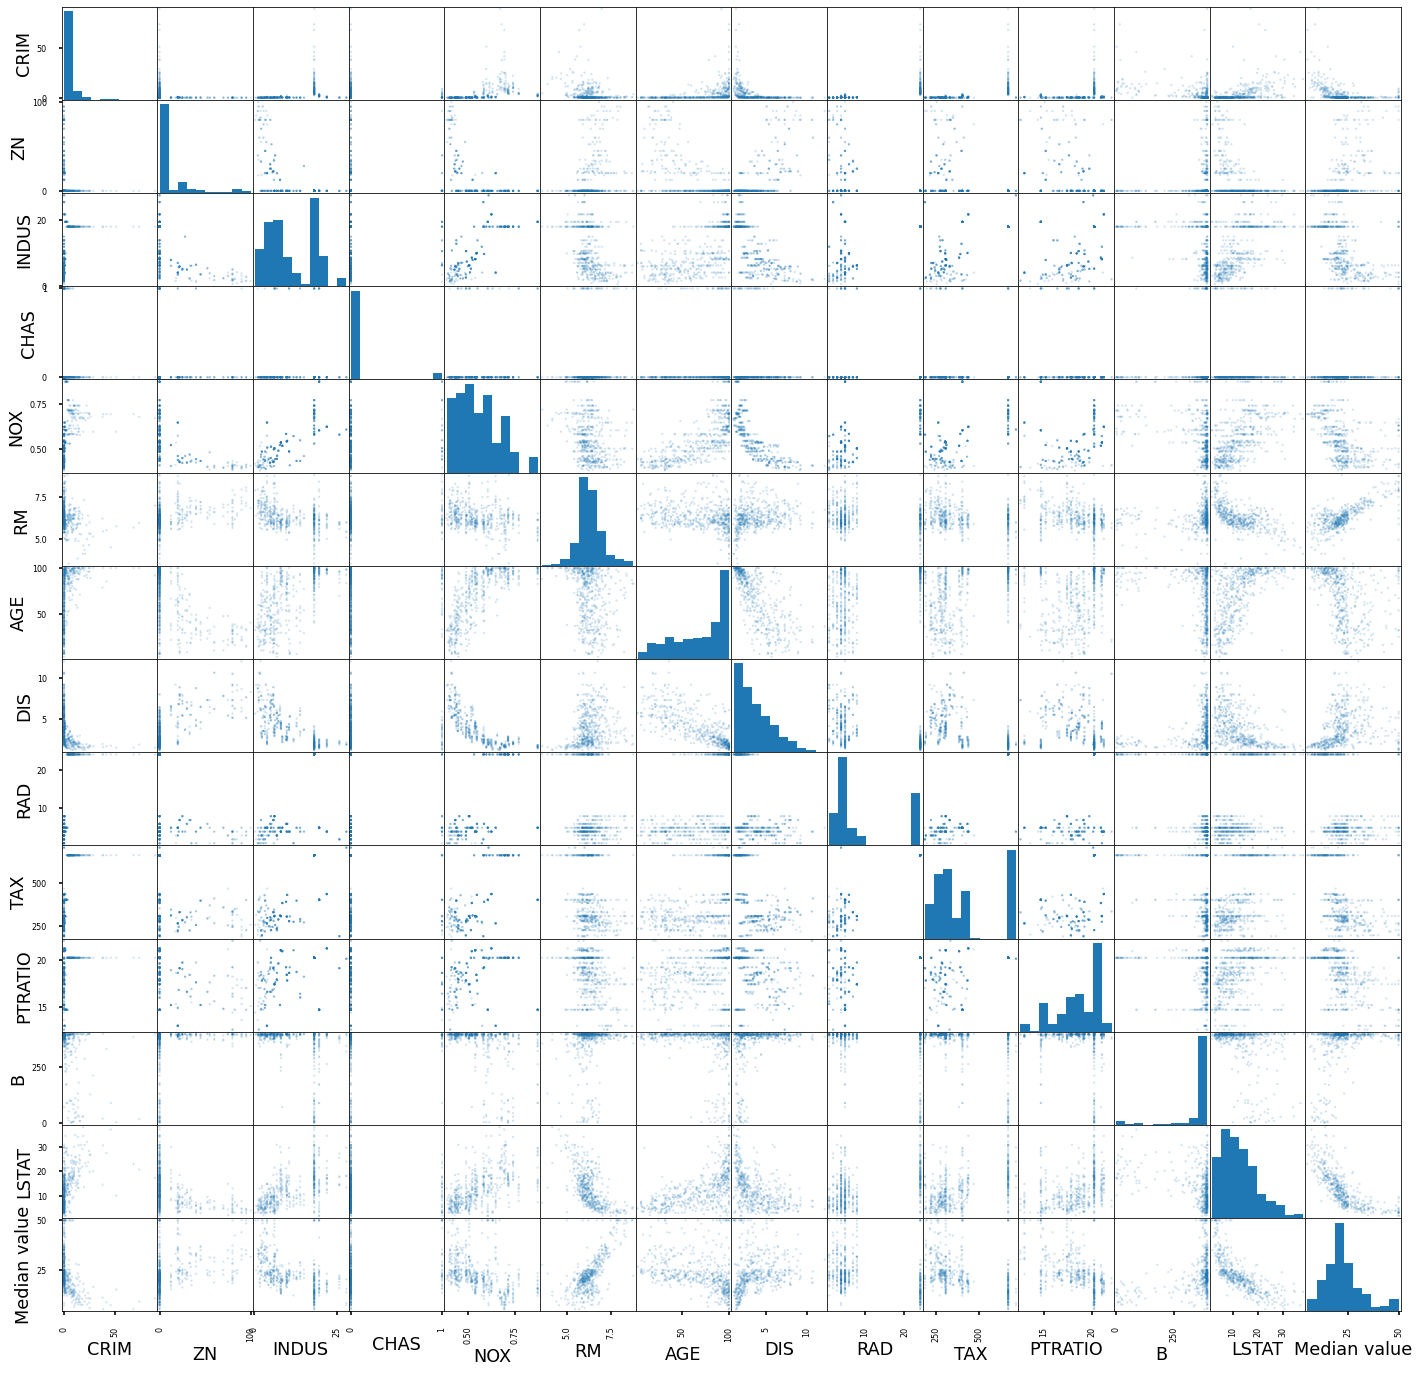

In [ ]:
df = pd.DataFrame(np.c_[boston.data, boston.target], columns=list(boston.feature_names) + ['Median value'])
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(24, 24), s=20)
plt.show()